<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PM2.5-AQI-Data-for-CLE,-LA,-NY,-and-Tampa-(1999-2022)" data-toc-modified-id="PM2.5-AQI-Data-for-CLE,-LA,-NY,-and-Tampa-(1999-2022)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PM2.5 AQI Data for CLE, LA, NY, and Tampa (1999-2022)</a></span><ul class="toc-item"><li><span><a href="#Cleaning-and-Preprocessing" data-toc-modified-id="Cleaning-and-Preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cleaning and Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Cleveland,-OH" data-toc-modified-id="Cleveland,-OH-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Cleveland, OH</a></span></li><li><span><a href="#Los-Angeles" data-toc-modified-id="Los-Angeles-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Los Angeles</a></span></li><li><span><a href="#New-York" data-toc-modified-id="New-York-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>New York</a></span></li><li><span><a href="#Tampa" data-toc-modified-id="Tampa-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Tampa</a></span></li></ul></li></ul></li><li><span><a href="#Causal-Impact" data-toc-modified-id="Causal-Impact-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Causal Impact</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Cleveland,-OH" data-toc-modified-id="Cleveland,-OH-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Cleveland, OH</a></span></li><li><span><a href="#Los-Angeles,-CA" data-toc-modified-id="Los-Angeles,-CA-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Los Angeles, CA</a></span></li><li><span><a href="#New-York,-NY" data-toc-modified-id="New-York,-NY-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>New York, NY</a></span></li><li><span><a href="#Tampa,-FL" data-toc-modified-id="Tampa,-FL-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Tampa, FL</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso

In [2]:
!pip install pycausalimpact

In [3]:
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

# PM2.5 AQI Data for CLE, LA, NY, and Tampa (1999-2022)

In [4]:
pth0 = r'D:\Tree-Canopy-Percentage-Air-Quality-Correlation-to-Acute-Resp-Illnesses-in-Ohio-cities-Project_\all_tables.xlsx'
df = pd.read_excel(pth0)
df.head(2)

,Unnamed: 0,Date,PM2.5 AQI Value,City,Month,Weekday,Year
0,0,1999-01-03,46,Cleveland,January,Sunday,1999
1,1,1999-01-06,62,Cleveland,January,Wednesday,1999


## Cleaning and Preprocessing

In [5]:
# Check total NaN values
df.isna().sum()

Unnamed: 0         0
Date               0
PM2.5 AQI Value    0
City               0
Month              0
Weekday            0
Year               0
dtype: int64

In [6]:
# Check city names
df.City.unique()

array(['Cleveland', 'Los Angeles', 'New York', 'Tampa'], dtype=object)

In [7]:
df.columns

Index(['Unnamed: 0', 'Date', 'PM2.5 AQI Value', 'City', 'Month', 'Weekday',
       'Year'],
      dtype='object')

We essentially just need date, PM2.5 AQI Value, and City. So let's create a new table with just that. 

In [8]:
df_aqi = df[['Date', 'PM2.5 AQI Value', 'City']]
df_aqi.head(4)

,Date,PM2.5 AQI Value,City
0,1999-01-03,46,Cleveland
1,1999-01-06,62,Cleveland
2,1999-01-08,112,Cleveland
3,1999-01-09,70,Cleveland


In [9]:
# Check data types
df_aqi.dtypes

Date               datetime64[ns]
PM2.5 AQI Value             int64
City                       object
dtype: object

In [10]:
df_aqi.Date = pd.to_datetime(df_aqi.Date, format='%Y-%m-*-%d')

In [11]:
df_aqi.head(5)

,Date,PM2.5 AQI Value,City
0,1999-01-03,46,Cleveland
1,1999-01-06,62,Cleveland
2,1999-01-08,112,Cleveland
3,1999-01-09,70,Cleveland
4,1999-01-10,82,Cleveland


In [12]:
df_aqi.dtypes

Date               datetime64[ns]
PM2.5 AQI Value             int64
City                       object
dtype: object

### Cleveland, OH

In [13]:
# Find index for Cleveland
i0 = df_aqi[((df_aqi.City == 'Cleveland'))].index
i0

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329],
           dtype='int64', length=7330)

In [14]:
# Create separate df for without CLE
no_cle = df_aqi.drop(i0)

# Set index and transform
no_cle = no_cle.set_index('Date')
no_cle.rename({'PM2.5 AQI Value':'1'}, axis=1, inplace=True)

# Separate df for only CLE
cle = df_aqi[((df_aqi.City == 'Cleveland'))]

# Set index and transform
cle = cle.set_index('Date')
cle.rename({'PM2.5 AQI Value':'0'}, axis=1, inplace=True)

# Remove duplicates
cle = cle[~cle.index.duplicated(keep='first')]
no_cle = no_cle[~no_cle.index.duplicated(keep='first')]

# Combine dataframes by using concat
combined = pd.concat([cle, no_cle], axis=1).drop(columns='City')

# Transform
transformed = combined.T
ds = transformed.fillna(transformed.median())

# Transform again
ds_combine_transformed = ds.T
ds_combine_transformed

,0,1
Date,,
1999-01-01,57.0,57.0
1999-01-02,33.0,33.0
1999-01-03,46.0,117.0
1999-01-04,90.0,90.0
1999-01-05,73.0,73.0
...,...,...
2022-05-30,49.0,55.0
2022-05-31,62.0,62.0
2022-06-01,66.0,66.0


### Los Angeles

In [15]:
# Find index for Los Angeles
i1 = df_aqi[((df_aqi.City == 'Los Angeles'))].index
i1

Int64Index([ 7330,  7331,  7332,  7333,  7334,  7335,  7336,  7337,  7338,
             7339,
            ...
            15459, 15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467,
            15468],
           dtype='int64', length=8139)

In [16]:
# Create separate df for without LA
no_la = df_aqi.drop(i1)
# Set index and transform
no_la = no_la.set_index('Date')
no_la.rename({'PM2.5 AQI Value':'1'}, axis=1, inplace=True)

# Separate df for only LA
la = df_aqi[((df_aqi.City == 'Los Angeles'))]
# Set index and transform
la = la.set_index('Date')
la.rename({'PM2.5 AQI Value':'0'}, axis=1, inplace=True)


# Remove duplicates
la = la[~la.index.duplicated(keep='first')]
no_la = no_la[~no_la.index.duplicated(keep='first')]

# Combine dataframes
combined1 = pd.concat([la, no_la], axis=1).drop(columns='City')

# Transform
transformed1 = combined1.T
ds1 = transformed1.fillna(transformed1.median())

# Transform
ds_combine_transformed1 = ds1.T
ds_combine_transformed1

,0,1
Date,,
1999-01-01,57.0,57.0
1999-01-02,33.0,33.0
1999-01-03,117.0,46.0
1999-01-04,90.0,54.0
1999-01-05,73.0,39.0
...,...,...
2022-05-30,55.0,49.0
2022-05-31,62.0,58.0
2022-06-01,66.0,39.0


### New York

In [17]:
# Find index for New York
i2 = df_aqi[((df_aqi.City == 'New York'))].index
i2

Int64Index([15469, 15470, 15471, 15472, 15473, 15474, 15475, 15476, 15477,
            15478,
            ...
            23742, 23743, 23744, 23745, 23746, 23747, 23748, 23749, 23750,
            23751],
           dtype='int64', length=8283)

In [18]:
# Create separate df for without NY
no_ny = df_aqi.drop(i2)
# Set index and transform
no_ny = no_ny.set_index('Date')
no_ny.rename({'PM2.5 AQI Value':'1'}, axis=1, inplace=True)

# Separate df for only NY
ny = df_aqi[((df_aqi.City == 'New York'))]
# Set index and transform
ny = ny.set_index('Date')
ny.rename({'PM2.5 AQI Value':'0'}, axis=1, inplace=True)


# Remove duplicates
ny = ny[~ny.index.duplicated(keep='first')]
no_ny = no_ny[~no_ny.index.duplicated(keep='first')]

# Combine dataframes
combined2 = pd.concat([ny, no_ny], axis=1).drop(columns='City')

# Transform
transformed2 = combined2.T
ds2 = transformed2.fillna(transformed2.median())

# Transform
ds_combine_transformed2 = ds2.T
ds_combine_transformed2

,0,1
Date,,
1999-01-01,57.0,57.0
1999-01-02,33.0,33.0
1999-01-03,52.0,46.0
1999-01-04,90.0,90.0
1999-01-05,73.0,73.0
...,...,...
2022-05-30,52.0,49.0
2022-05-31,58.0,62.0
2022-06-01,39.0,66.0


### Tampa

In [19]:
# Find index for Tampa
i3 = df_aqi[((df_aqi.City == 'Tampa'))].index
i3

Int64Index([23752, 23753, 23754, 23755, 23756, 23757, 23758, 23759, 23760,
            23761,
            ...
            32210, 32211, 32212, 32213, 32214, 32215, 32216, 32217, 32218,
            32219],
           dtype='int64', length=8468)

In [20]:
# Create separate df for without Tampa
no_tpa = df_aqi.drop(i2)
# Set index and transform
no_tpa = no_tpa.set_index('Date')
no_tpa.rename({'PM2.5 AQI Value':'1'}, axis=1, inplace=True)

# Separate df for only Tampa
tpa = df_aqi[((df_aqi.City == 'Tampa'))]
# Set index and transform
tpa = tpa.set_index('Date')
tpa.rename({'PM2.5 AQI Value':'0'}, axis=1, inplace=True)


# Remove duplicates
tpa = tpa[~tpa.index.duplicated(keep='first')]
no_tpa = no_tpa[~no_tpa.index.duplicated(keep='first')]

# Combine dataframes
combined3 = pd.concat([tpa, no_tpa], axis=1).drop(columns='City')

# Transform
transformed3 = combined3.T
ds3 = transformed3.fillna(transformed3.median())

# Transform
ds_combine_transformed3 = ds3.T
ds_combine_transformed3

,0,1
Date,,
1999-01-01,57.0,57.0
1999-01-02,33.0,33.0
1999-01-03,34.0,46.0
1999-01-04,54.0,90.0
1999-01-05,39.0,73.0
...,...,...
2022-05-30,30.0,49.0
2022-05-31,32.0,62.0
2022-06-01,31.0,66.0


# Causal Impact

### Cleveland, OH

In [21]:
# Create pre and post periods
pre_period = ['1999-01-01','2017-12-31'] 
post_period = ['2018-01-01','2022-06-03']
pre_period

['1999-01-01', '2017-12-31']

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    45.58              73609.0
Prediction (s.d.)         42.45 (6.72)       68564.18 (10846.94)
95% CI                    [29.62, 55.95]     [47840.68, 90359.89]

Absolute effect (s.d.)    3.12 (6.72)        5044.82 (10846.94)
95% CI                    [-10.37, 15.96]    [-16750.89, 25768.32]

Relative effect (s.d.)    7.36% (15.82%)     7.36% (15.82%)
95% CI                    [-24.43%, 37.58%]  [-24.43%, 37.58%]

Posterior tail-area probability p: 0.33
Posterior prob. of a causal effect: 66.73%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 45.58. In the absence of an
intervention, we would have expected an average response of 42.45.
The 95% interval of this counterfactual prediction is [29.62, 55.95].
Subtracting this prediction 

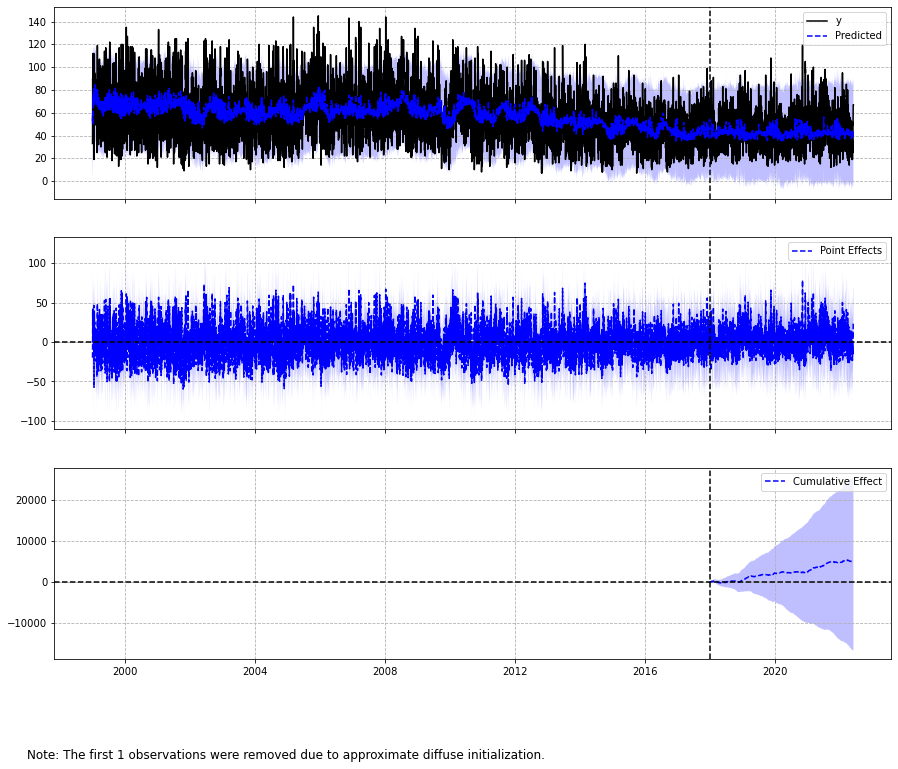

In [22]:
ci0 = CausalImpact(ds_combine_transformed.astype(float), pre_period, post_period)
print(ci0.summary())
print(ci0.summary(output='report'))
ci0.plot()

### Los Angeles, CA

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    62.76              101362.0
Prediction (s.d.)         72.63 (6.4)        117304.04 (10331.91)
95% CI                    [59.95, 85.03]     [96817.09, 137317.43]

Absolute effect (s.d.)    -9.87 (6.4)        -15942.04 (10331.91)
95% CI                    [-22.26, 2.81]     [-35955.43, 4544.91]

Relative effect (s.d.)    -13.59% (8.81%)    -13.59% (8.81%)
95% CI                    [-30.65%, 3.87%]   [-30.65%, 3.87%]

Posterior tail-area probability p: 0.06
Posterior prob. of a causal effect: 94.31%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 62.76. In the absence of an
intervention, we would have expected an average response of 72.63.
The 95% interval of this counterfactual prediction is [59.95, 85.03].
Subtracting this predict

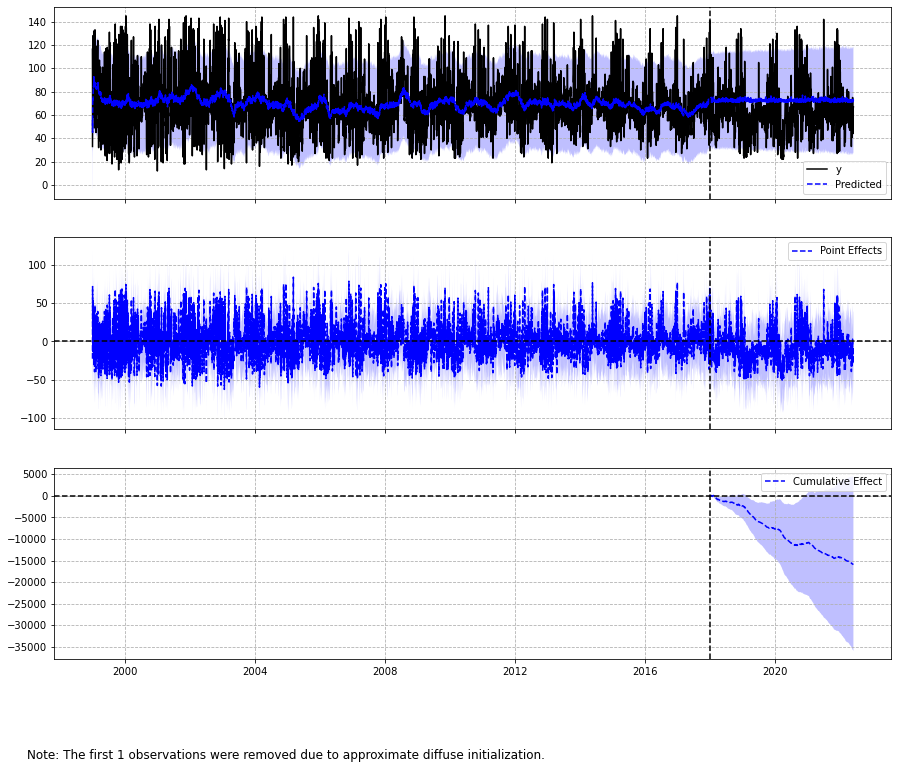

In [23]:
ci1 = CausalImpact(ds_combine_transformed1.astype(float), pre_period, post_period)
print(ci1.summary())
print(ci1.summary(output='report'))
ci1.plot()

### New York, NY

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    46.52              75135.0
Prediction (s.d.)         50.94 (6.11)       82275.46 (9867.88)
95% CI                    [38.27, 62.22]     [61810.18, 100491.57]

Absolute effect (s.d.)    -4.42 (6.11)       -7140.46 (9867.88)
95% CI                    [-15.7, 8.25]      [-25356.57, 13324.82]

Relative effect (s.d.)    -8.68% (11.99%)    -8.68% (11.99%)
95% CI                    [-30.82%, 16.2%]   [-30.82%, 16.2%]

Posterior tail-area probability p: 0.22
Posterior prob. of a causal effect: 77.82%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 46.52. In the absence of an
intervention, we would have expected an average response of 50.94.
The 95% interval of this counterfactual prediction is [38.27, 62.22].
Subtracting this prediction 

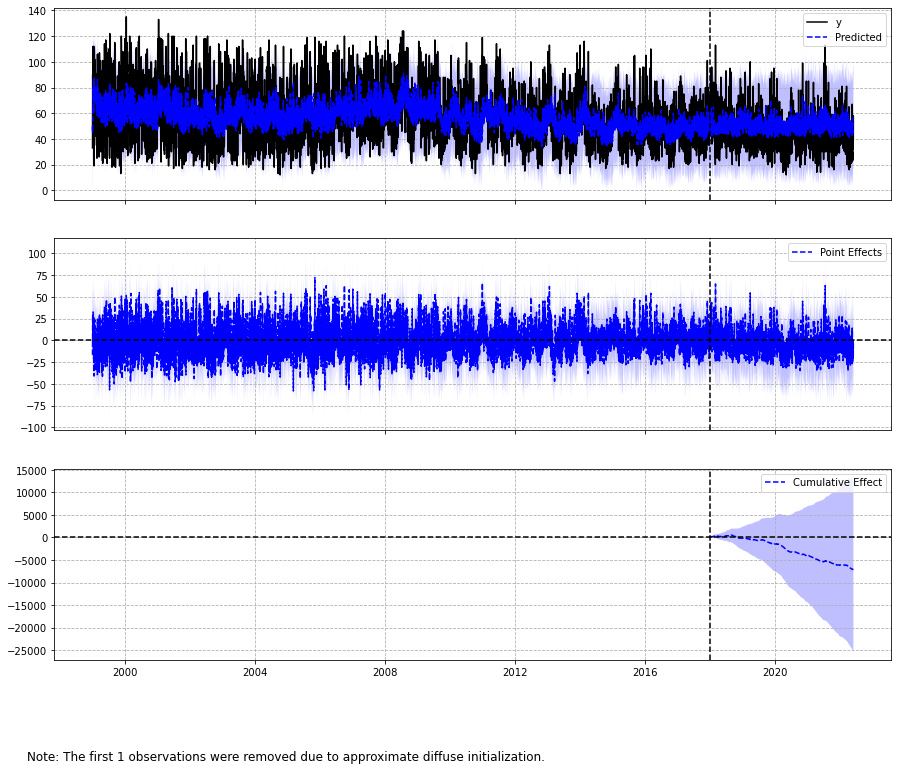

In [24]:
ci2 = CausalImpact(ds_combine_transformed2.astype(float), pre_period, post_period)
print(ci2.summary())
print(ci2.summary(output='report'))
ci2.plot()

### Tampa, FL

D:\User\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\User\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\User\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    40.25              65008.0
Prediction (s.d.)         40.49 (3.9)        65391.38 (6294.63)
95% CI                    [32.73, 48.01]     [52854.32, 77528.83]

Absolute effect (s.d.)    -0.24 (3.9)        -383.38 (6294.63)
95% CI                    [-7.75, 7.53]      [-12520.83, 12153.68]

Relative effect (s.d.)    -0.59% (9.63%)     -0.59% (9.63%)
95% CI                    [-19.15%, 18.59%]  [-19.15%, 18.59%]

Posterior tail-area probability p: 0.47
Posterior prob. of a causal effect: 52.65%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 40.25. In the absence of an
intervention, we would have expected an average response of 40.49.
The 95% interval of this counterfactual prediction is [32.73, 48.01].
Subtracting this prediction fr

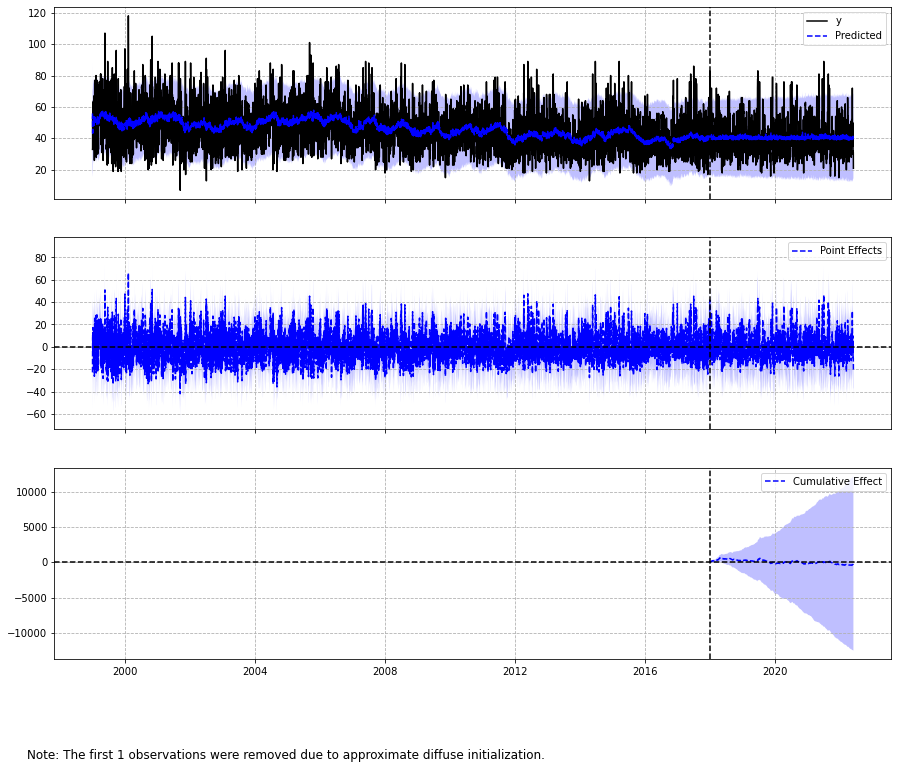

In [26]:
ci3 = CausalImpact(ds_combine_transformed3.astype(float), pre_period, post_period)
print(ci3.summary())
print(ci3.summary(output='report'))
ci3.plot()